In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import json

# 1. Explore COCO Annotations

In [2]:
## To download the coco annotations

# ! wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
# ! unzip annotations_trainval2014.zip

In [4]:
ins_train = json.load(open('./annotations/instances_train2017.json', 'r'))

In [5]:
## Clean up the files

# ! rm -rf ./annotations/
# ! rm annotations_trainval2014.zip

In [46]:
## checkout the README of this part to find out how the mapping was obtained

# with open('./category_mapping.json', 'r') as f:
#     category_mapping = json.load(f)

In [6]:
## top level keys
ins_train.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

## `categories`

In [7]:
len(ins_train['categories']), ins_train['categories'][0]

(80, {'supercategory': 'person', 'id': 1, 'name': 'person'})

In [8]:
categories = ins_train['categories']
category_mapping = {r['id']:r['name'] for r in categories}

## to store mapping locally
# with open('./coco_category_mapping.json', 'w') as fw:
#     json.dump(category_mapping, fw)

category_mapping

{1: 'person',
 2: 'bicycle',
 3: 'car',
 4: 'motorcycle',
 5: 'airplane',
 6: 'bus',
 7: 'train',
 8: 'truck',
 9: 'boat',
 10: 'traffic light',
 11: 'fire hydrant',
 13: 'stop sign',
 14: 'parking meter',
 15: 'bench',
 16: 'bird',
 17: 'cat',
 18: 'dog',
 19: 'horse',
 20: 'sheep',
 21: 'cow',
 22: 'elephant',
 23: 'bear',
 24: 'zebra',
 25: 'giraffe',
 27: 'backpack',
 28: 'umbrella',
 31: 'handbag',
 32: 'tie',
 33: 'suitcase',
 34: 'frisbee',
 35: 'skis',
 36: 'snowboard',
 37: 'sports ball',
 38: 'kite',
 39: 'baseball bat',
 40: 'baseball glove',
 41: 'skateboard',
 42: 'surfboard',
 43: 'tennis racket',
 44: 'bottle',
 46: 'wine glass',
 47: 'cup',
 48: 'fork',
 49: 'knife',
 50: 'spoon',
 51: 'bowl',
 52: 'banana',
 53: 'apple',
 54: 'sandwich',
 55: 'orange',
 56: 'broccoli',
 57: 'carrot',
 58: 'hot dog',
 59: 'pizza',
 60: 'donut',
 61: 'cake',
 62: 'chair',
 63: 'couch',
 64: 'potted plant',
 65: 'bed',
 67: 'dining table',
 70: 'toilet',
 72: 'tv',
 73: 'laptop',
 74: 'mo

## `annotations`

In [12]:
len(ins_train['annotations']), ins_train['annotations'][0]

(860001,
 {'segmentation': [[239.97,
    260.24,
    222.04,
    270.49,
    199.84,
    253.41,
    213.5,
    227.79,
    259.62,
    200.46,
    274.13,
    202.17,
    277.55,
    210.71,
    249.37,
    253.41,
    237.41,
    264.51,
    242.54,
    261.95,
    228.87,
    271.34]],
  'area': 2765.1486500000005,
  'iscrowd': 0,
  'image_id': 558840,
  'bbox': [199.84, 200.46, 77.71, 70.88],
  'category_id': 58,
  'id': 156})

In [10]:
all_image_ids = [x['id'] for x in ins_train['images']]
len(all_image_ids)

118287

In [11]:
bbox_df = pd.DataFrame([x['bbox'] for x in ins_train['annotations']], columns=['x','y','width','height'])
bbox_df.describe()

,x,y,width,height
count,860001.000000,860001.000000,860001.000000,860001.000000
mean,243.461816,193.013263,103.894745,107.418773
std,169.405320,119.673263,127.618042,114.852586
min,0.000000,0.000000,0.230000,0.000000
25%,99.240000,103.330000,23.210000,27.720000
50%,230.820000,186.910000,54.140000,62.340000
75%,370.500000,269.850000,128.500000,144.970000
max,638.340000,635.130000,640.000000,640.000000


In [15]:
all_cats = [x['category_id'] for x in ins_train['annotations']]

counts_label = Counter(all_cats).most_common()
# print(f'class `person` is {round(262465 / 43867)}X bigger than class `car`')

In [16]:
def plot_counts(counts_label, title='COCO category counts'):
    plt.figure(figsize=(17, 4))
    x = [n[0] for n in counts_label]
    x_labels = [category_mapping[n[0]] for n in counts_label]
    y = [n[1] for n in counts_label]

    plt.bar(x, y, color='green', align='center', width=0.9)
    plt.title(title)
    plt.xticks(x, x_labels, rotation='vertical')
    plt.show()

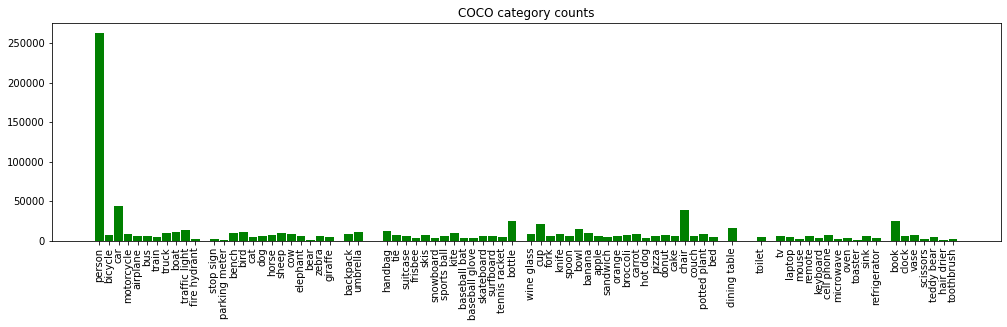

In [17]:
plot_counts(counts_label)

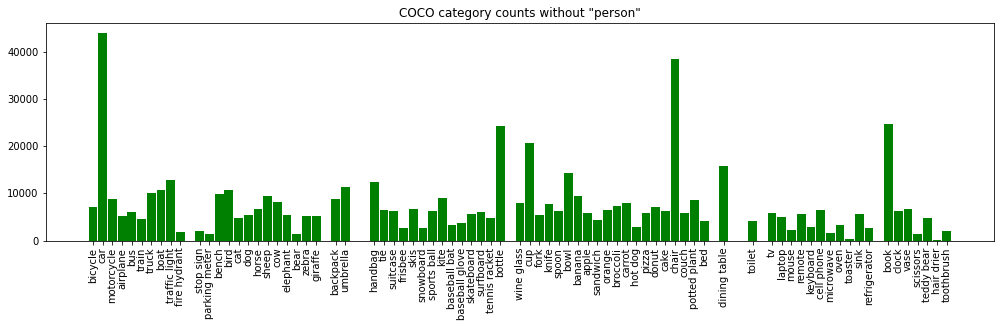

In [18]:
plot_counts(counts_label[1:], title='COCO category counts without "person"')

## `images`

In [20]:
ins_train['images'][0]

{'license': 3,
 'file_name': '000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

# 2. K-means with sample_coco.txt 

In [21]:
def parse_line(text, keys_to_extract=['bbox', 'width', 'height', 'id']):
    """
    turns a non quote json content to dict
    eg:
        'id: 0, height: 330, width: 1093, bbox:[69, 464, 312, 175],'
        to
        {'bbox': [69, 464, 312, 175], 'width': 1093, 'height': 330, 'id': 0}
    Arguments:
        text: str, the content to be extracted
        keys_to_extract: list, the expected keys in the content, ⚠️ in reverse order!
    Returns:
        parsed_content: dict
    """
    parsed_content = {}
    start = None
    for key_name in keys_to_extract:
        stop, start = start, text.index(key_name)
        content = text[start:stop].strip(', ')
        k, v = [x.strip(' ') for x in content.split(':')]
        parsed_content[k] = eval(v)
    return parsed_content

In [22]:
with open('./sample_coco.txt', 'r') as f:
    coco_data = [parse_line(x.strip()) for x in f.readlines()]

In [27]:
coco_data[:3]

[{'bbox': [69, 464, 312, 175], 'width': 1093, 'height': 330, 'id': 0},
 {'bbox': [359, 292, 83, 199], 'width': 439, 'height': 782, 'id': 1},
 {'bbox': [297, 312, 267, 167], 'width': 831, 'height': 645, 'id': 3}]

In [36]:
coco_data_unravel = [
    {
        'id': item['id'],
        'width': item['width'],
        'height': item['height'],
        'x': item['bbox'][0],
        'y': item['bbox'][1],
        'b_w': item['bbox'][2],
        'b_h': item['bbox'][3],
    }
    for item in coco_data
]

coco_data_df = pd.DataFrame(coco_data_unravel)

coco_data_df['n_width'] = coco_data_df['width'] / coco_data_df['width']
coco_data_df['n_x'] = coco_data_df['x'] / coco_data_df['width']
coco_data_df['n_b_w'] = coco_data_df['b_w'] / coco_data_df['width']

coco_data_df['n_height'] = coco_data_df['height'] / coco_data_df['height']
coco_data_df['n_y'] = coco_data_df['y'] / coco_data_df['height']
coco_data_df['n_b_h'] = coco_data_df['b_h'] / coco_data_df['height']

coco_data_df

,id,width,height,x,y,b_w,b_h,n_width,n_x,n_b_w,n_height,n_y,n_b_h
0,0,1093,330,69,464,312,175,1.0,0.063129,0.285453,1.0,1.406061,0.530303
1,1,439,782,359,292,83,199,1.0,0.817768,0.189066,1.0,0.373402,0.254476
2,3,831,645,297,312,267,167,1.0,0.357401,0.321300,1.0,0.483721,0.258915
3,34,608,943,275,112,319,290,1.0,0.452303,0.524671,1.0,0.118770,0.307529
4,20,857,593,71,368,146,147,1.0,0.082847,0.170362,1.0,0.620573,0.247892
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,2,550,285,62,129,234,142,1.0,0.112727,0.425455,1.0,0.452632,0.498246
10101,37,340,735,389,78,140,158,1.0,1.144118,0.411765,1.0,0.106122,0.214966
10102,15,665,677,359,240,297,258,1.0,0.539850,0.446617,1.0,0.354505,0.381093
10103,69,653,474,95,168,271,138,1.0,0.145482,0.415008,1.0,0.354430,0.291139


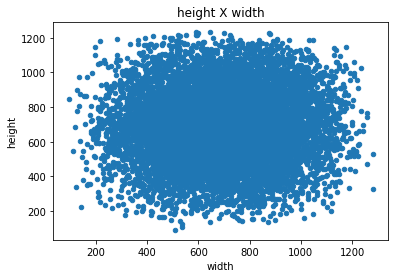

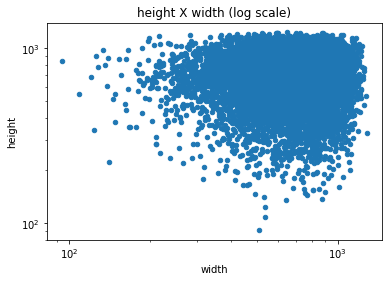

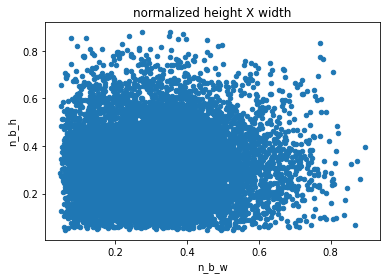

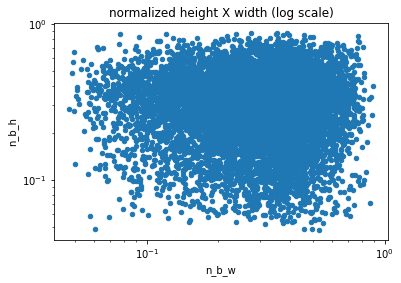

In [50]:
coco_data_df.plot.scatter(x='width', y='height', title='height X width')
coco_data_df.plot.scatter(x='width', y='height', loglog=True, title='height X width (log scale)')
coco_data_df.plot.scatter(x='n_b_w', y='n_b_h', title='normalized height X width')
coco_data_df.plot.scatter(x='n_b_w', y='n_b_h', loglog=True, title='normalized height X width (log scale)')

## K-means modeling

In [61]:
from sklearn.cluster import KMeans
import numpy as np
import cv2 as cv

In [125]:
X = coco_data_df[['n_b_w', 'n_b_h']]
ks = 3, 4, 5, 6

offset = 75
img_size = 300
get_x_y = lambda w, h: ((img_size // 2) - (w // 2), (img_size // 2) - (h // 2))

In [126]:
## compute clusters
clusters = {}
for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    cluster_temp = kmeans.cluster_centers_
    print(k, cluster_temp)
    clusters[k] = cluster_temp

3 [[0.21808862 0.23992734]
 [0.47845166 0.27415007]
 [0.29415167 0.49028161]]
4 [[0.48039999 0.27216026]
 [0.2051795  0.38941535]
 [0.2465304  0.18169721]
 [0.38567446 0.53267178]]
5 [[0.3694134  0.52645624]
 [0.19569039 0.40160753]
 [0.38165884 0.23765644]
 [0.18873836 0.18674727]
 [0.58115784 0.31787939]]
6 [[0.58733195 0.34421703]
 [0.17048974 0.40305196]
 [0.19006843 0.19288712]
 [0.40408074 0.17250223]
 [0.35610559 0.35966085]
 [0.33583787 0.59193606]]


In [129]:
clusters

{3: array([[0.21808862, 0.23992734],
        [0.47845166, 0.27415007],
        [0.29415167, 0.49028161]]),
 4: array([[0.48039999, 0.27216026],
        [0.2051795 , 0.38941535],
        [0.2465304 , 0.18169721],
        [0.38567446, 0.53267178]]),
 5: array([[0.3694134 , 0.52645624],
        [0.19569039, 0.40160753],
        [0.38165884, 0.23765644],
        [0.18873836, 0.18674727],
        [0.58115784, 0.31787939]]),
 6: array([[0.58733195, 0.34421703],
        [0.17048974, 0.40305196],
        [0.19006843, 0.19288712],
        [0.40408074, 0.17250223],
        [0.35610559, 0.35966085],
        [0.33583787, 0.59193606]])}

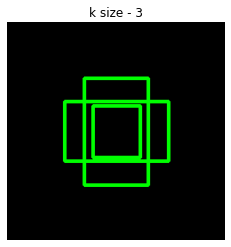

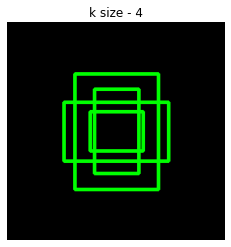

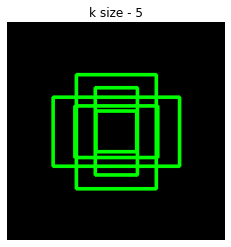

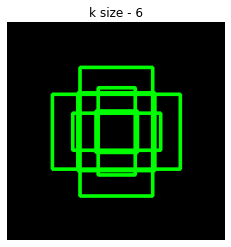

In [132]:
for k, cluster in clusters.items():
    image = np.zeros((img_size, img_size, 3), np.uint8)
    for w, h in cluster:
        s_w, s_h = int(img_size * w), int(img_size * h)
        x, y = get_x_y(s_w, s_h)
        x2, y2 = x + s_w, y + s_h
        image = cv.rectangle(image, (x, y), (x2, y2), (0,255,0), 3)
        
    plt.imshow(image)
    plt.title(f'k size - {k}')
    plt.axis('off')
    plt.show()